# Reproduction and analysis of Phil's figures
This notebook is to reproduce and add a little bit to the anlysis of Phil's paper.

In [1]:
from __future__ import print_function
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

from network import BCPNN, NetworkManager, BCPNNFast, Protocol
from data_transformer import build_ortogonal_patterns
from plotting_functions import plot_state_variables_vs_time, plot_network_activity, plot_network_activity_angle
from plotting_functions import  plot_adaptation_dynamics, plot_weight_matrix, plot_winning_pattern, plot_sequence

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

np.set_printoptions(suppress=True, precision=2)

sns.set(font_scale=2.0)

#### Git machinery

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = '8694da3b241624adc178ea3c52e82f7356c7e1ee'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

## Plot 4
First we get the general parameters and build the network

In [3]:
# Patterns parameters
hypercolumns = 4
minicolumns = 15
n_patterns = 10  # Number of patterns

# Manager properties
dt = 0.001
T_recalling = 10.0
values_to_save = ['o']

# Protocol
training_time = 0.1
inter_sequence_interval = 1.0
inter_pulse_interval = 0.0
epochs = 20

Now we build the Network, Manager and Training Protocol

In [4]:
# Build patterns
patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:n_patterns]

# Build the network
nn = BCPNNFast(hypercolumns, minicolumns, epsilon=0.5*1e-3)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Build the protocol for training
protocol = Protocol()
protocol.simple_protocol(patterns, training_time=training_time, inter_pulse_interval=inter_pulse_interval,
                         inter_sequence_interval=inter_sequence_interval, epochs=epochs)

We train the network and process the data

In [5]:
# Train
epoch_history = manager.run_network_protocol(protocol=protocol, verbose=False, values_to_save_epoch=['w'])
w_history = epoch_history['w']

from_pattern = 0
w_epoch = [w_t[:, from_pattern].reshape(nn.hypercolumns, nn.minicolumns) for w_t in w_history]
w_epoch = [np.mean(w, axis=0) for w in w_epoch]
w_epoch = np.array(w_epoch)

#### Plot the data

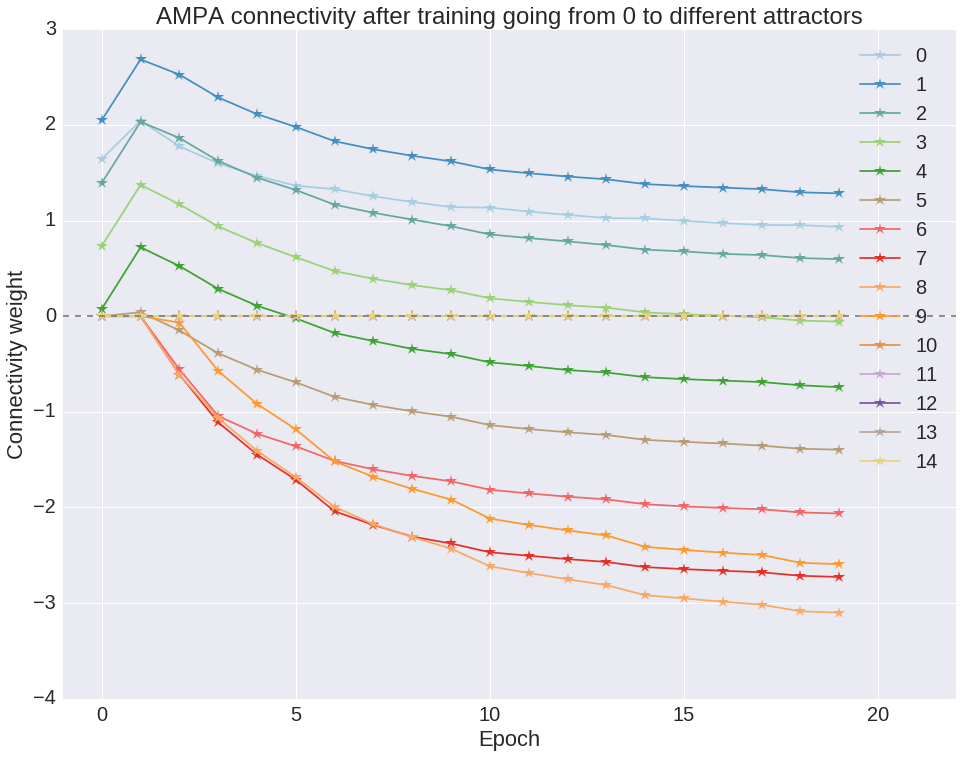

In [6]:
cmap_string = 'nipy_spectral'
cmap_string = 'hsv'
cmap_string = 'Paired'

cmap = matplotlib.cm.get_cmap(cmap_string)
norm = matplotlib.colors.Normalize(vmin=0, vmax=minicolumns)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

for index, w in enumerate(w_epoch.T):
    ax.plot(w, '*-', color=cmap(norm(index)), markersize=12, label=str(index))

ax.axhline(y=0, color='gray', linestyle='--')
ax.set_xlim([-1, epochs + 2])
ax.set_xlabel('Epoch')
ax.set_ylabel('Connectivity weight')
ax.set_title('AMPA connectivity after training going from 0 to different attractors')
ax.legend();

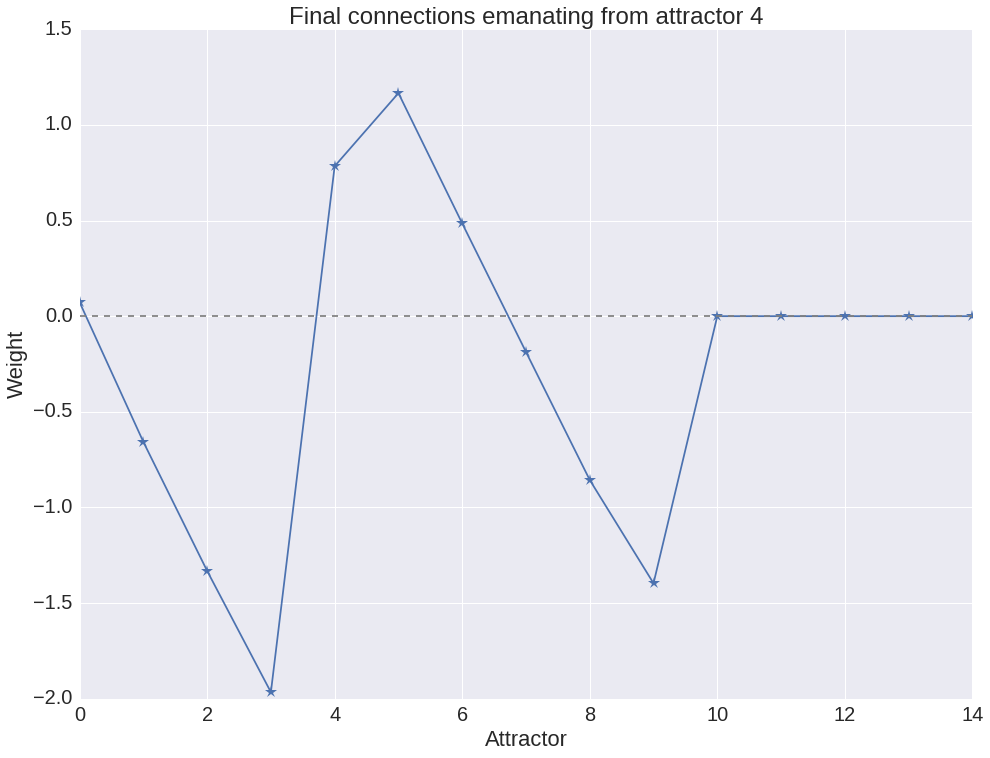

In [7]:
from_pattern = 4
w_final = w_history[-1][:, from_pattern].reshape((hypercolumns, minicolumns)).mean(axis=0)

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(w_final, '*-', markersize=12)
ax.axhline(y=0, color='grey', linestyle='--')

ax.set_xlabel('Attractor')
ax.set_ylabel('Weight')
ax.set_title('Final connections emanating from attractor ' + str(from_pattern))
plt.show()

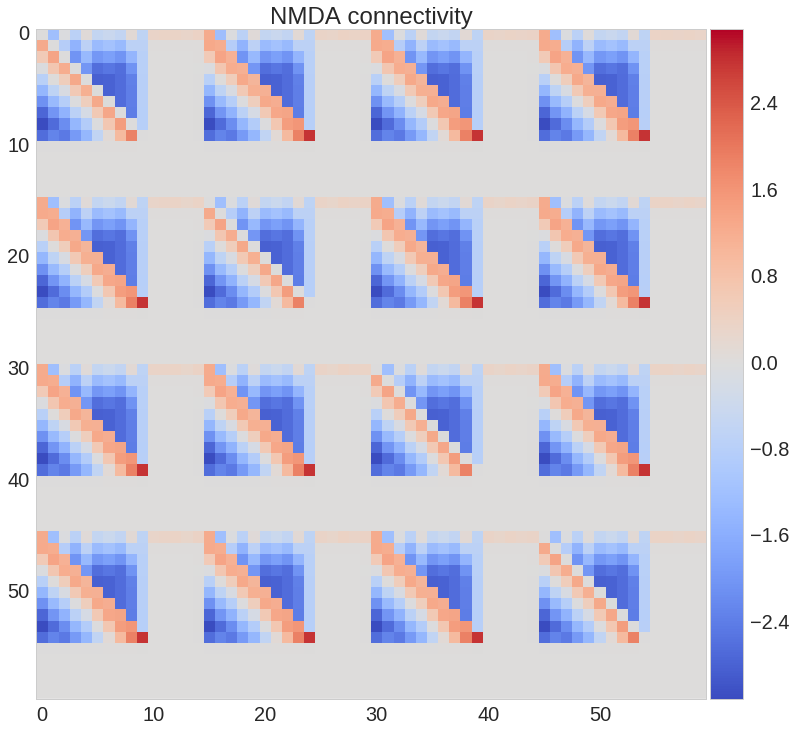

In [8]:
plot_weight_matrix(nn)

#### Git recovery

In [9]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])